In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
n = 120
X = np.linspace(-4, 6, n).reshape(-1, 1)
noise = np.random.normal(0, 6, n)
y = 0.5 * X.flatten()**3 - 3 *X.flatten()**2 + 2* X.flatten() + noise
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
len(X_train), len(X_test)

(90, 30)

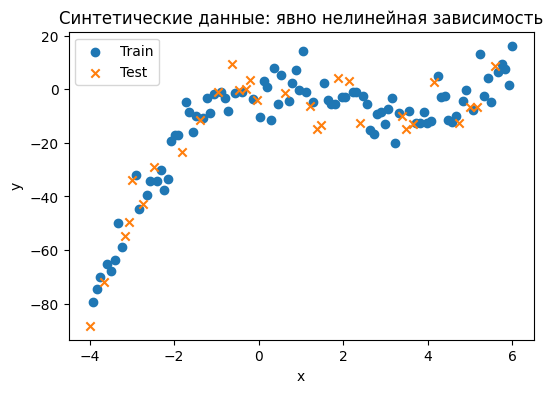

In [3]:
plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, label="Test", marker="x")
plt.title("Синтетические данные: явно нелинейная зависимость")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [4]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred_train_lin = lin_model.predict(X_train)
y_pred_test_lin  = lin_model.predict(X_test)

r2_lin_train = r2_score(y_train, y_pred_train_lin)
r2_lin_test  = r2_score(y_test,  y_pred_test_lin)

rmse_lin_train = mean_squared_error(y_train, y_pred_train_lin)**0.5
rmse_lin_test  = mean_squared_error(y_test,  y_pred_test_lin)**0.5

print("Линейная регрессия:")
print(f"  Train R^2 = {r2_lin_train:.3f}, Test R^2 = {r2_lin_test:.3f}")
print(f"  Train RMSE = {rmse_lin_train:.3f}, Test RMSE = {rmse_lin_test:.3f}")

Линейная регрессия:
  Train R^2 = 0.452, Test R^2 = 0.420
  Train RMSE = 15.090, Test RMSE = 17.841



| Метрика | Значение | Что значит |
|--------|---------|-----------|
| **Train R² = 0.460** | На тренировочных данных модель объясняет ~46% вариации | Нормально для кривой зависимости |
| **Test R² = 0.415** | На тестовых тоже ~41% | Модель не переобучена, но недообучена |
| **Train RMSE ≈ 16.0** | Среднее отклонение от реальных значений | Ошибка велика, так как модель слишком простая |
| **Test RMSE ≈ 18.5** | Ошибка чуть больше на тесте | Хороший признак: модель не переобучена |

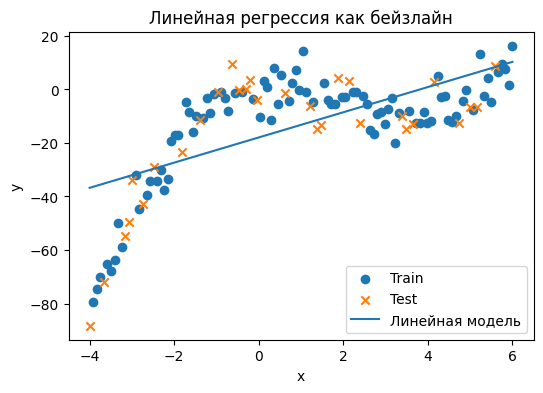

In [5]:
x_grid = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_grid_lin = lin_model.predict(x_grid)

plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, label="Test", marker="x")
plt.plot(x_grid, y_grid_lin, label="Линейная модель")
plt.title("Линейная регрессия как бейзлайн")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [6]:

# Конвейер (без стандартизации, т.к. у нас один признак x; для многих признаков можно добавить StandardScaler)
poly_pipe = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("lin", LinearRegression())
])

# Сетка по степеням полинома
param_grid = {
    "poly__degree": list(range(1, 11))  # степени от 1 до 10
}

# 5-кратная кросс-валидация, оптимизируем по RMSE (минимум)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    estimator=poly_pipe,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # чем больше, тем лучше (отрицательный RMSE)
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_degree = grid.best_params_["poly__degree"]
best_cv_rmse = -grid.best_score_

print(f"Лучшая степень полинома по CV: {best_degree}")
print(f"Лучший CV RMSE: {best_cv_rmse:.3f}")

Лучшая степень полинома по CV: 3
Лучший CV RMSE: 5.823


In [7]:
# Сводная таблица по степеням: Train/Test R^2 и RMSE
from sklearn.metrics import r2_score, root_mean_squared_error

rows = []
for d in range(1, 11):
    pipe = Pipeline([
        ("poly", PolynomialFeatures(degree=d, include_bias=False)),
        ("lin", LinearRegression())
    ])
    pipe.fit(X_train, y_train)

    y_tr = pipe.predict(X_train)
    y_te = pipe.predict(X_test)

    rows.append({
        "degree": d,
        "train_R2": r2_score(y_train, y_tr),
        "test_R2": r2_score(y_test, y_te),
        "train_RMSE": root_mean_squared_error(y_train, y_tr),
        "test_RMSE": root_mean_squared_error(y_test, y_te),
    })

metrics_df = pd.DataFrame(rows).set_index("degree")
metrics_df


,train_R2,test_R2,train_RMSE,test_RMSE
degree,,,,
1,0.452029,0.420173,15.089881,17.840721
2,0.704599,0.733013,11.079314,12.106199
3,0.926260,0.926098,5.535520,6.369272
4,0.927655,0.923945,5.482908,6.461422
5,0.928851,0.922336,5.437393,6.529381
6,0.928908,0.922238,5.435203,6.533506
7,0.929127,0.919655,5.426832,6.641119
8,0.929333,0.916466,5.418939,6.771642
9,0.931720,0.914105,5.326649,6.866679


In [8]:
# Отобразим таблицу

metrics_df.head()

,train_R2,test_R2,train_RMSE,test_RMSE
degree,,,,
1,0.452029,0.420173,15.089881,17.840721
2,0.704599,0.733013,11.079314,12.106199
3,0.926260,0.926098,5.535520,6.369272
4,0.927655,0.923945,5.482908,6.461422
5,0.928851,0.922336,5.437393,6.529381


In [9]:

best_model = Pipeline([
    ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
    ("lin", LinearRegression())
])
best_model.fit(X_train, y_train)

y_pred_train_best = best_model.predict(X_train)
y_pred_test_best  = best_model.predict(X_test)

print("Лучшая модель (по CV):")
print(f"  Степень = {best_degree}")
print(f"  Train R^2 = {r2_score(y_train, y_pred_train_best):.3f}, Test R^2 = {r2_score(y_test, y_pred_test_best):.3f}")
print(f"  Train RMSE = {root_mean_squared_error(y_train, y_pred_train_best):.3f}, Test RMSE = {root_mean_squared_error(y_test, y_pred_test_best):.3f}")


Лучшая модель (по CV):
  Степень = 3
  Train R^2 = 0.926, Test R^2 = 0.926
  Train RMSE = 5.536, Test RMSE = 6.369


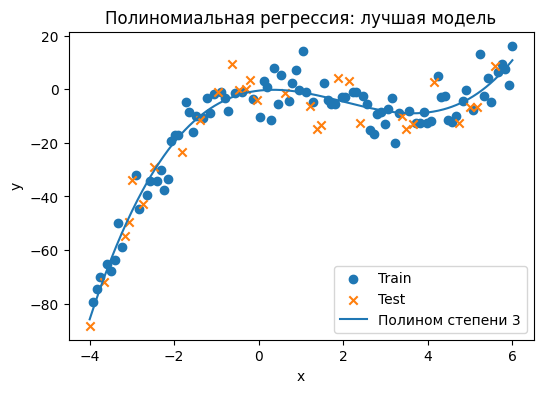

In [10]:
# Гладкий график аппроксимации на плотной сетке
x_dense = np.linspace(X.min(), X.max(), 400).reshape(-1, 1)
y_dense_best = best_model.predict(x_dense)

plt.figure(figsize=(6,4))
plt.scatter(X_train, y_train, label="Train")
plt.scatter(X_test, y_test, label="Test", marker="x")
plt.plot(x_dense, y_dense_best, label=f"Полином степени {best_degree}")
plt.title("Полиномиальная регрессия: лучшая модель")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

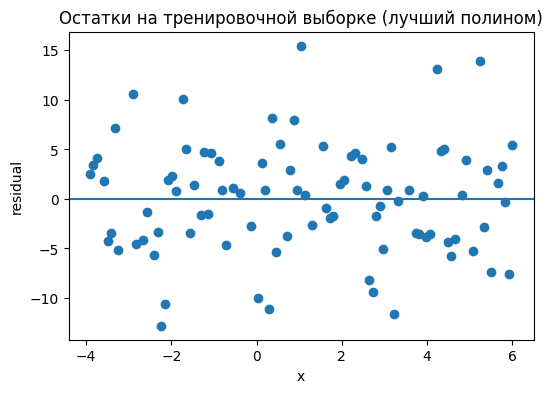

In [11]:
residuals = y_train - y_pred_train_best

plt.figure(figsize=(6,4))
plt.scatter(X_train, residuals)
plt.axhline(0)
plt.title("Остатки на тренировочной выборке (лучший полином)")
plt.xlabel("x")
plt.ylabel("residual")
plt.show()

In [12]:
def fit_metrics_for_degree(d):
    pipe = Pipeline([("poly", PolynomialFeatures(degree=d, include_bias=False)),
                     ("lin", LinearRegression())])
    pipe.fit(X_train, y_train)
    ytr = pipe.predict(X_train)
    yte = pipe.predict(X_test)
    return pipe, {
        "degree": d,
        "train_R2": r2_score(y_train, ytr),
        "test_R2": r2_score(y_test,  yte),
        "train_RMSE": root_mean_squared_error(y_train, ytr),
        "test_RMSE": root_mean_squared_error(y_test,  yte),
    }

model_low, m_low = fit_metrics_for_degree(1)
model_best, m_best = best_model, {
    "degree": best_degree,
    "train_R2": r2_score(y_train, best_model.predict(X_train)),
    "test_R2":  r2_score(y_test,  best_model.predict(X_test)),
    "train_RMSE": root_mean_squared_error(y_train, best_model.predict(X_train)),
    "test_RMSE":  root_mean_squared_error(y_test,  best_model.predict(X_test)),
}
model_high, m_high = fit_metrics_for_degree(12)

pd.DataFrame([m_low, m_best, m_high])

,degree,train_R2,test_R2,train_RMSE,test_RMSE
0,1,0.452029,0.420173,15.089881,17.840721
1,3,0.926260,0.926098,5.535520,6.369272
2,12,0.934939,0.895753,5.199561,7.564771


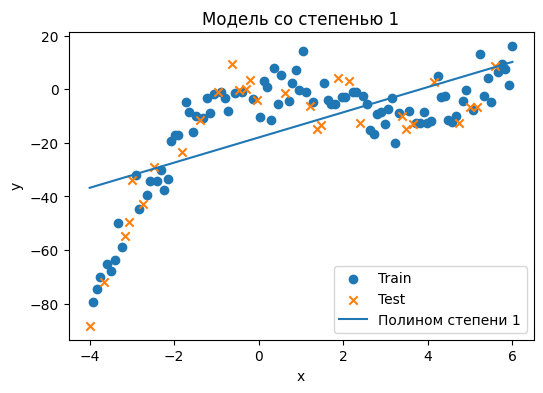

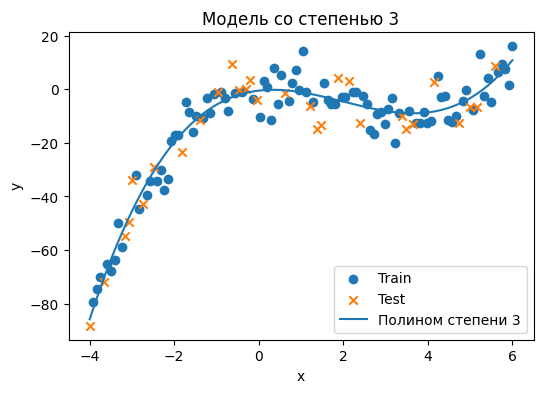

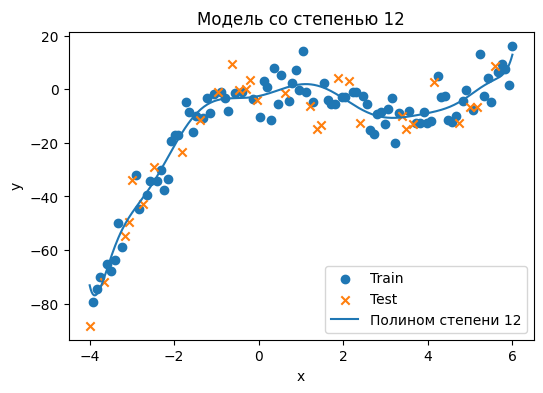

In [13]:
for d, model in [(1, model_low), (best_degree, model_best), (12, model_high)]:
    plt.figure(figsize=(6,4))
    y_curve = model.predict(x_dense)
    plt.scatter(X_train, y_train, label="Train")
    plt.scatter(X_test, y_test, label="Test", marker="x")
    plt.plot(x_dense, y_curve, label=f"Полином степени {d}")
    plt.title(f"Модель со степенью {d}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()


In [14]:
ridge_pipe = Pipeline([
    ("poly", PolynomialFeatures(degree=10, include_bias=False)),
    ("ridge", Ridge(alpha=10.0, random_state=42))
])
ridge_pipe.fit(X_train, y_train)

y_pred_test_ridge = ridge_pipe.predict(X_test)

print("Ridge + полиномиальные признаки (degree=10, alpha=10):")
print(f"  Test R^2  = {r2_score(y_test, y_pred_test_ridge):.3f}")
print(f"  Test RMSE = {root_mean_squared_error(y_test, y_pred_test_ridge):.3f}")


Ridge + полиномиальные признаки (degree=10, alpha=10):
  Test R^2  = 0.915
  Test RMSE = 6.814
